# Mel + Mel Shifted = Mel
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the mel and shifted mel to train the neural network.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

In [2]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [3]:
n_ffts = 2048
n_mels = 256
n_mfcc = 40

In [4]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training
data_label_pairs_flat, data_label_pairs_dict = create_data_label_pairs(n_pitches)

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

The first cell involves 3d arrays, while the second cell involves flattened arrays.

In [6]:
# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list. n_windows is 115 with 75% overlap.
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 1025, 29) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 256, 29) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 40, 29)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, overlap=.5, plot=False) 
                              for waveform in all_wav_data ])

all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

n_files, _, n_windows = all_mfcc.shape

print("all_wav_data shape = " , all_wav_data.shape)
print("all_spectrograms shape = ", all_spectrograms.shape)
print("all_mels shape = ", all_mels.shape)
print("all_mfcc shape = ", all_mfcc.shape)

all_wav_data shape =  (576,)
all_spectrograms shape =  (576, 1025, 29)
all_mels shape =  (576, 256, 29)
all_mfcc shape =  (576, 40, 29)


### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.


In [7]:
# Flatten data

# Create data accessor for flat arrays
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# Create flat mel spectra 
# flat_mels: (16704, 256)
flat_mels_prenorm = np.array([ all_mels[wav_file_idx][:, window_idx] 
                               for wav_file_idx in range(n_files) 
                               for window_idx in range(n_windows) ])

# Globally normalize to [-1, 1]
flat_mels_logged = np.log(flat_mels_prenorm)
max_mels = np.max(np.abs(flat_mels_logged))
flat_mels = flat_mels_logged / max_mels

print(flat_mels.shape)


(16704, 256)


In [8]:
# Create mfccs features
# flat_mfcc: (16704, 40)
flat_mfcc_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx]
                               for wav_file_idx in range(n_files)
                               for window_idx in range(n_windows) ])

# Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1]
flat_mfcc_signs = np.sign(flat_mfcc_prenorm)
flat_mfcc_logged = np.log(np.abs(flat_mfcc_prenorm))
max_mfcc = np.max(np.abs(flat_mfcc_logged))
flat_mfcc = flat_mfcc_logged / max_mfcc
flat_mfcc = torch.Tensor(flat_mfcc)

print(flat_mfcc.shape)

torch.Size([16704, 40])


In [9]:
# Create fft features
# flat_spec: (16704, 1025)
flat_spec_prenorm = np.array([ all_spectrograms[wav_file_idx][:, window_idx] 
                          for wav_file_idx in range(n_files) 
                          for window_idx in range(n_windows) ])

# Globally normalize to [-1, 1]
flat_spec_logged = np.log(flat_spec_prenorm)
max_spec = np.max(np.abs(flat_spec_logged))
flat_spec = flat_spec_logged / max_spec

print(flat_spec.shape)

(16704, 1025)


Visualization in plot

In [10]:
# # Visualize and verify Mels
# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plt.figure()
# fig.suptitle("Mels Confirmation", fontsize=16)
# ax[0].plot(flat_mels_prenorm[0])
# ax[0].set_title("Flat Mels Prenorm: {}".format(flat_mels_prenorm.shape))
# ax[1].plot(flat_mels[0])
# ax[1].set_title("Flat Mels (one example): {}".format(flat_mels.shape))
# ax[2].plot(np.e ** (flat_mels[0] * max_mels))
# ax[2].set_title("Restored Mels: {}".format(flat_mels.shape))

# # Visualize and verify MFCC
# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plt.figure()
# fig.suptitle("MFCC Confirmation", fontsize=16)
# ax[0].plot(flat_mfcc_prenorm.T)
# ax[0].set_title("Flat MFCC Prenorm: {}".format(flat_mfcc_prenorm.shape))
# ax[1].plot(flat_mfcc.T)
# ax[1].set_title("Flat MFCC (one example): {}".format(flat_mfcc.detach().numpy().shape))
# ax[2].plot((flat_mfcc_signs * np.e ** (flat_mfcc.detach().numpy() * max_mfcc)).T)
# ax[2].set_title("Restored MFCC: {}".format(flat_mfcc.detach().numpy().shape))

## Pre-Training - Autoencoder stage

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from timbre features on mfcc and mel spectrums. `labels` are abs(fft) spectrograms. At this stage, pre-training, we simply want to make the NN learn to output fourier spectra.

Note that mel_spectra/mfcc of abs(fft) are equivalent to those of fft itself.

In [12]:
# Create labels

# data:   (16704, 296) (n_wavs * n_windows, n_mfcc + n_mels)
# labels: (16704, 256) (n_wavs * n_windows, flat_mels / 2 + 1)
data = np.concatenate((flat_mels, flat_mels), axis=1)
labels = flat_mels
print(data.shape, labels.shape)

(16704, 512) (16704, 256)


Test-Train split: 1 person from each wav will be the test data

In [13]:
# X_train, Y_train: (11136, 296) (11136, 256) 
# X_val, Y_val:     (5568, 296)  (5568, 256)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_train, Y_train, X_val, Y_val))

# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

torch.Size([11136, 512]) torch.Size([5568, 512]) torch.Size([11136, 256]) torch.Size([5568, 256])


Normalize `labels_prenorm` to range [-1,1]

In [14]:
# plt.figure()
# plt.plot(data)

# # labels, label_scales = normalize_rows(labels_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
# # plt.figure()
# # plt.plot(labels_prenorm)

# labels_prenorm_log = np.log(labels_prenorm)
# label_scales = np.amax(np.absolute(labels_prenorm_log))
# labels  = labels_prenorm_log / label_scales

# # plt.figure()
# # plt.plot(labels)

# print(data.shape, labels.shape)

## Training Procedure (decoder style, no pitch shift)

This takes mel + mel spectrum, and tries to recreate the original FFT.

In [18]:
n_input = 512; n_hid = 512;
# n_ffts = 1025;
lr = 1e-3; n_epochs = 500; batch_size=22272//8;

# Training model 
model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)

loss_fn = nn.MSELoss()

In [19]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


[-0.04655778  0.01859101  0.11991325 -0.02209047  0.07815705 -0.02429569
 -0.14577805  0.06839836  0.04110668 -0.06189857 -0.06912246  0.09914622
 -0.11620077 -0.06397124  0.05545536  0.01927534 -0.09121942  0.00696469
  0.04890776 -0.08544302  0.0938964  -0.02763055 -0.06343655 -0.05684534
 -0.04001419 -0.09738084 -0.03484182 -0.00228445 -0.0346827   0.10243624
  0.09587173  0.15404727 -0.14796537 -0.0232509   0.02712773 -0.03083837
 -0.01707583  0.03460195 -0.06978086 -0.04300435 -0.1592071   0.08776941
 -0.01520199 -0.05184041  0.0214717   0.01180425 -0.05381944 -0.05188348
  0.04414133  0.07332841  0.0207534   0.06741153  0.03450969 -0.08274619
  0.06543086  0.0190536  -0.09606862  0.01208863  0.01161775 -0.0592465
  0.0498547   0.01129492 -0.1003225  -0.00668276 -0.00282684  0.06187992
  0.07447717  0.06668629  0.07716154 -0.01370398  0.02001262  0.00225551
  0.18489948  0.05651127 -0.007806    0.01849776 -0.09786861  0.11826582
  0.00497419 -0.09136163  0.01361228  0.08445247  0.

[ 0.1217187   0.11531542  0.121513    0.16860627  0.34418398  0.26148644
  0.34021333  0.2564441   0.22918399  0.07511964  0.14404055  0.27576932
  0.29303366  0.37670186  0.19183189  0.21179393  0.03424205  0.14901757
  0.30665448  0.2450885   0.2321619   0.20852353  0.13697994  0.16245149
  0.22437812  0.26166105  0.20617041  0.2555858   0.2171149   0.14620751
  0.02857369  0.13997278  0.31801346  0.33296016  0.31480685  0.30740944
  0.19725946  0.23358616  0.25471386  0.27163807  0.12314858  0.00456389
 -0.33185795 -0.17412496 -0.06384834  0.04070308  0.19817251  0.10536217
 -0.00257439 -0.17356573 -0.12772477 -0.07374651 -0.0231263   0.08236678
  0.0536322   0.04886552 -0.02310075 -0.16507128 -0.15164343 -0.0686644
 -0.0559556  -0.00661652 -0.02278395 -0.11240204 -0.21242845 -0.13189456
 -0.05119063  0.03401834  0.0242849  -0.03136253 -0.10569946 -0.12581153
 -0.14932102 -0.1626745  -0.14156249 -0.09636417 -0.12761042 -0.06636508
 -0.08610907 -0.05773387 -0.07090759 -0.06121847 -0.

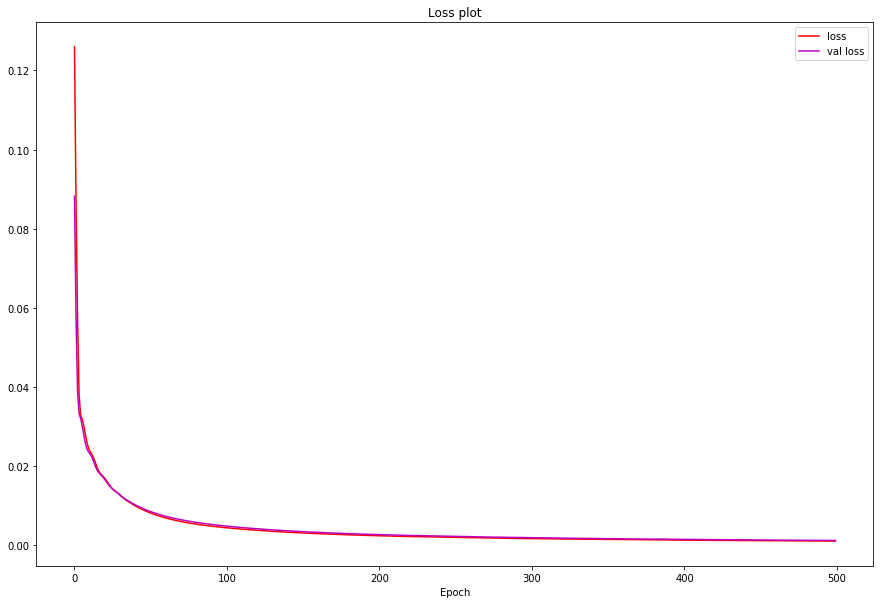

Training Loss before/after: 0.12594486773014069, 0.0010189367458224297
Validation Loss before/after: 0.08819807320833206, 0.001180651830509305
Final loss: 0.0010189367458224297
Time taken: 23.12136960029602


In [20]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device)

# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))

Saving the model

In [21]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
model_path = os.path.join("model_data", "TimbreFNNDecoder_mels-mels_{}_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_mels, n_hid, n_ffts, train_loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\TimbreFNNDecoder_mels-mels_0.001_500_40_256_512_2048_0.0010189367458224297.pt


Loading the saved model, and using the model for prediction example

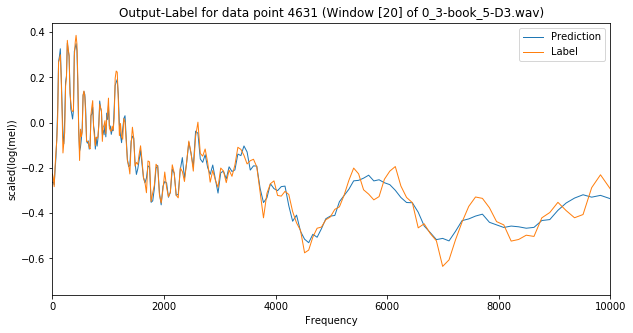

In [22]:
vidx = 3; pIdx = 5; pid = 0; winIdx = 20;
wavIdx = flat_ref_idx(vidx, pIdx, pid)

model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.float(); 
predictions = model(data_tensor).detach().numpy()


# x_axis = librosa.core.fft_frequencies(sample_rate, 1024)
# plt.figure(figsize=(10, 5))
# plt.plot(x_axis, predictions[30000], label='Prediction', linewidth=1)
# plt.plot(x_axis, label_tensor[30000], label='Label', linewidth=1)
# plt.xlim(0, 5000)
# plt.xlabel('Frequency')
# plt.ylabel('abs(fft)')
# plt.legend(loc='best')
# title = "lr" + str(lr) + " n_epochs" + str(n_epochs) + " n_mfcc" + str(n_mfcc) + " n_mels" + str(n_mels) + " n_hid" + str(n_hid) + " n_ffts" + str(n_ffts) + " train_loss" + str(train_loss)
# plt.title("TimbreFNN_mels-fft " + title)

# plt.savefig(model_path + '.png')


# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Graphing of a single mel spectra for one datapoint  #
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
data_point = flat_data_idx(wavIdx, winIdx)
x_axis = librosa.core.mel_frequencies(n_mels=256, fmin=0.0, fmax=22050.0)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions[data_point], label='Prediction', linewidth=1)
plt.plot(x_axis, label_tensor[data_point], label='Label', linewidth=1)
plt.xlim(0, 10000)
plt.xlabel('Frequency')
plt.ylabel('scaled(log(mel))')
plt.legend(loc='best')
plt.title("Output-Label for data point {} (Window [{}] of {})".format(data_point, winIdx, flat_data_ref_list[wavIdx]))
title = "TimbreFNN_mels-mels "+ "lr" + str(lr) + " n_epochs" + str(n_epochs) + " n_mfcc" + str(n_mfcc) + " n_mels" + str(n_mels) + " n_hid" + str(n_hid) + " n_ffts" + str(n_ffts) + " train_loss" + str(train_loss)
# plt.title("TimbreFNN_mels-mels " + title)

plt.savefig(model_path + '.png')

## Training - Waveform conformation

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from {mels} features (which requires the use of the TimbreVAE) and mel spectrums. `labels` are {mels} spectrograms. At this stage, we want the ANN to learn to conform pitch shifted mel spectra to the correct form.

In [27]:
def create_training_dataset(n_ffts, overlap, n_mels,
                            shift_amt, sparsity_factor = 8):
    print('Creating dataset for shift_amt = {}'.format(shift_amt))
    
    # Initialize shift_amt dependent data structures
    pairs = data_label_pairs_dict[shift_amt]
    # all_pitched_spectra: (576, 1025, 29)
    _, all_pitched_spectra = resample_pitch_shift(all_wav_data, shift_amt, overlap, n_ffts=n_ffts)
    # all_mels: (576, 256, 29)
    all_pitched_mels_prenorm = np.array([ ffts_to_mel(ffts, n_mels = n_mels, skip_mfcc=True) 
                                          for ffts in all_pitched_spectra ])
    all_pitched_mels_prenorm_logged = np.log(all_pitched_mels_prenorm)
    max_pitched_mels = np.max(np.abs(all_pitched_mels_prenorm_logged))
    all_pitched_mels = all_pitched_mels_prenorm_logged / max_pitched_mels

    X_train = []; X_val = []; Y_train = []; Y_val = [];
    list_of_test_idx = []
    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):
            # If the pair is valid (does not go out of range), then proceed.
            if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:
                # Choose the person for this pitch/vowel to be used as test data.
                test_pid = int(np.random.rand() * 3)

                for pid_idx in range(n_people):
                    # Wav index
                    wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                    wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)
                    # Window index lower-upper bounds
                    data_flat_start_idx = flat_data_idx(wav_idx, 0)
                    data_flat_end_idx = flat_data_idx(wav_idx + 1, 0)
                    label_flat_start_idx = flat_data_idx(wav_idx_shifted, 0)
                    label_flat_end_idx = flat_data_idx(wav_idx_shifted + 1, 0)
                    # Get the x(n_datapoints, n_mels + n_mels), y(n_datapoints, n_mels)
                    x_item = np.hstack((flat_mels[data_flat_start_idx:data_flat_end_idx], 
                                        all_pitched_mels[wav_idx].T))[0::sparsity_factor]
                    y_item = flat_mels[label_flat_start_idx:label_flat_end_idx][0::sparsity_factor]
                        
                    if (pid_idx != test_pid):
                        X_train.extend(x_item)
                        Y_train.extend(y_item)
                    else:
                        X_val.extend(x_item)
                        Y_val.extend(y_item)
                        list_of_test_idx.append((wav_idx,wav_idx_shifted))
                        
    X_train = np.array(X_train); Y_train = np.array(Y_train);
    X_val = np.array(X_val); Y_val = np.array(Y_val);
    print("X_train: {}, Y_train: {}, X_val: {}, Y_val: {}".format(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape))

    list_of_test_idx = np.array(list_of_test_idx)
    return X_train, Y_train, X_val, Y_val, list_of_test_idx, max_pitched_mels, all_pitched_mels

In [28]:
# n_ffts = 2048; overlap = 0.5;
# n_input = 262; n_hid = 262; n_output = 256; 
# n_mels = 256; n_mfcc = 12; n_timb_hid = 10; n_timb = 6

overlap = 0.5

pitch_shift_amts = [ -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
sparsities = np.array([11, 12, 13, 14, 15, 16, 15, 14, 13, 12, 11])

X_train=[]; Y_train=[]; X_val=[]; Y_val=[]
for idx, pitch_shift_amt in enumerate(pitch_shift_amts):
    print(idx)
    _X_train, _Y_train, _X_val, _Y_val, list_of_test_idx, max_pitched_mels, all_pitched_mels = \
        create_training_dataset(n_ffts, overlap, n_mels, pitch_shift_amt, sparsity_factor = sparsities[idx])
    X_train.extend(_X_train)
    Y_train.extend(_Y_train)
    X_val.extend(_X_val)
    Y_val.extend(_Y_val)
    
X_train, Y_train, X_val, Y_val = map(np.array, (X_train, Y_train, X_val, Y_val))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
X_train, Y_train, X_val, Y_val = map(torch.Tensor, (X_train, Y_train, X_val, Y_val))
X_train.float(); Y_train.float(); X_val.float(); Y_val.float();

0
Creating dataset for shift_amt = -5
X_train: (792, 512), Y_train: (792, 256), X_val: (396, 512), Y_val: (396, 256)
1
Creating dataset for shift_amt = -4
X_train: (864, 512), Y_train: (864, 256), X_val: (432, 512), Y_val: (432, 256)
2
Creating dataset for shift_amt = -3
X_train: (936, 512), Y_train: (936, 256), X_val: (468, 512), Y_val: (468, 256)
3
Creating dataset for shift_amt = -2
X_train: (1008, 512), Y_train: (1008, 256), X_val: (504, 512), Y_val: (504, 256)
4
Creating dataset for shift_amt = -1
X_train: (720, 512), Y_train: (720, 256), X_val: (360, 512), Y_val: (360, 256)
5
Creating dataset for shift_amt = 0
X_train: (768, 512), Y_train: (768, 256), X_val: (384, 512), Y_val: (384, 256)
6
Creating dataset for shift_amt = 1
X_train: (720, 512), Y_train: (720, 256), X_val: (360, 512), Y_val: (360, 256)
7
Creating dataset for shift_amt = 2
X_train: (1008, 512), Y_train: (1008, 256), X_val: (504, 512), Y_val: (504, 256)
8
Creating dataset for shift_amt = 3
X_train: (936, 512), Y_tra

Text(0.5, 1.0, 'X_train + X_val spectra')

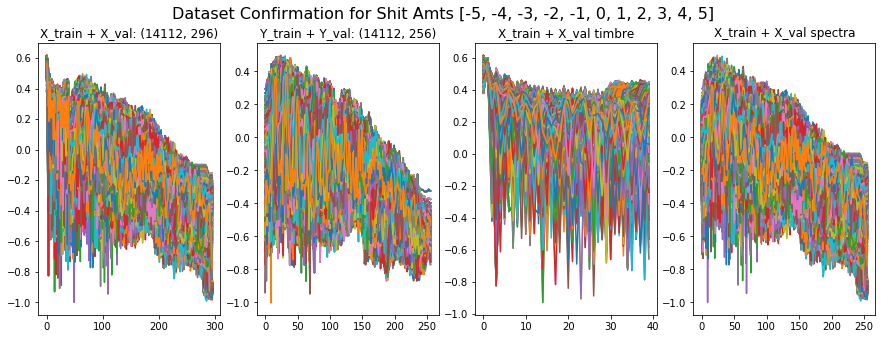

<Figure size 432x288 with 0 Axes>

In [55]:
# # Visualize and verify Mels
# fig, ax = plt.subplots(1, 4, figsize=(15,5))
# plt.figure()
# fig.suptitle("Dataset Confirmation for Shit Amts {}".format(pitch_shift_amts), fontsize=16)
# ax[0].plot(np.concatenate((X_train, X_val)).T)
# ax[0].set_title("X_train + X_val: {}".format(np.concatenate((X_train, X_val)).shape))
# ax[1].plot(np.concatenate((Y_train, Y_val)).T)
# ax[1].set_title("Y_train + Y_val: {}".format(np.concatenate((Y_train, Y_val)).shape))
# ax[2].plot(np.concatenate((X_train, X_val)).T[:n_mfcc,:])
# ax[2].set_title("X_train + X_val timbre")
# ax[3].plot(np.concatenate((X_train, X_val)).T[n_mfcc:,:])
# ax[3].set_title("X_train + X_val spectra")

### Waveform Conformation Stage - MFCC + Mel -> Mel 

This takes a mfcc vector and pitch shifted spectrum, and tries to recreate something similar to an actual spectrum of that new pitch.


In [30]:
n_input = 2*n_mels; n_hid = 512; 
# n_ffts = 1025;
lr = 1e-3; n_epochs = 500; batch_size=22272//8;

# Transfer learning - we take the model from the autoencoder stage
model_path = os.path.join("model_data", "TimbreFNNDecoder_mels-mels_0.001_500_40_256_512_2048_0.0010189367458224297.pt")
model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)
model.load_state_dict(torch.load(model_path))
model.eval()

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Training model 
# model = TimbreMelDecoder(n_input=n_input, n_hid=n_hid, n_output=n_output)

# Define loss 
loss_fn = nn.MSELoss()

Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])


[ 0.20999439  0.13187674  0.15663442  0.13310872  0.23176567  0.21518372
  0.26157054  0.27175465  0.200564    0.08358235  0.13416252  0.1809196
  0.15418878  0.20401813  0.10527472  0.1931565   0.14925714  0.2138072
  0.27015212  0.2268913   0.16393323  0.1549587   0.15627062  0.14057039
  0.24408686  0.25199163  0.26451164  0.24023272  0.17099941  0.1401744
  0.09137899  0.10731228  0.12839071  0.20181668  0.2564792   0.24839105
  0.16172701  0.16945578  0.1158972   0.10003381  0.01042589 -0.00518173
 -0.05019341  0.01668411  0.10009819  0.15994635  0.15154278  0.12112044
  0.0869737   0.03173411 -0.01104371  0.07670395  0.05118534 -0.00207428
 -0.01638997  0.00529959 -0.01464995 -0.01947055 -0.08643425 -0.05947873
 -0.06344208  0.00882012  0.04015012  0.02734948  0.03025735 -0.0687297
 -0.08987997 -0.08538521 -0.1046353  -0.08859108 -0.0632245  -0.04355941
 -0.01994071  0.01973944 -0.00783347 -0.07163554 -0.12141868 -0.02821659
  0.01910855  0.026522    0.02545032 -0.00460202  0.031

[ 0.09351633  0.07272105  0.10155881  0.14703435  0.20152456  0.22628263
  0.258102    0.2343045   0.20134921  0.11188362  0.13555893  0.21286777
  0.22051582  0.23116274  0.20676798  0.23640516  0.16914643  0.22625336
  0.19972765  0.24167995  0.2234669   0.2047725   0.22236995  0.22684988
  0.26983377  0.27473032  0.28204656  0.2601149   0.18770549  0.14171879
  0.13407709  0.15193419  0.21294415  0.23508106  0.2640731   0.25640488
  0.18480328  0.1773847   0.15851666  0.1286049   0.09218258  0.06928874
  0.05377311  0.07360268  0.10085402  0.08396258  0.11762396  0.0953697
  0.07184264  0.06104175 -0.01226017  0.02359688  0.01026823  0.04481112
  0.05671018  0.06903316  0.02964172 -0.02994357 -0.04539836 -0.04229821
 -0.03781581  0.00408045  0.00087395 -0.05099386 -0.02270384 -0.04365572
 -0.03288583 -0.03285927 -0.08744138 -0.0724311  -0.07620219 -0.10050111
 -0.07731267 -0.02689296 -0.04584099 -0.04460534 -0.09274799 -0.09114323
 -0.10291706 -0.09042209 -0.08183648 -0.08865402 -0.

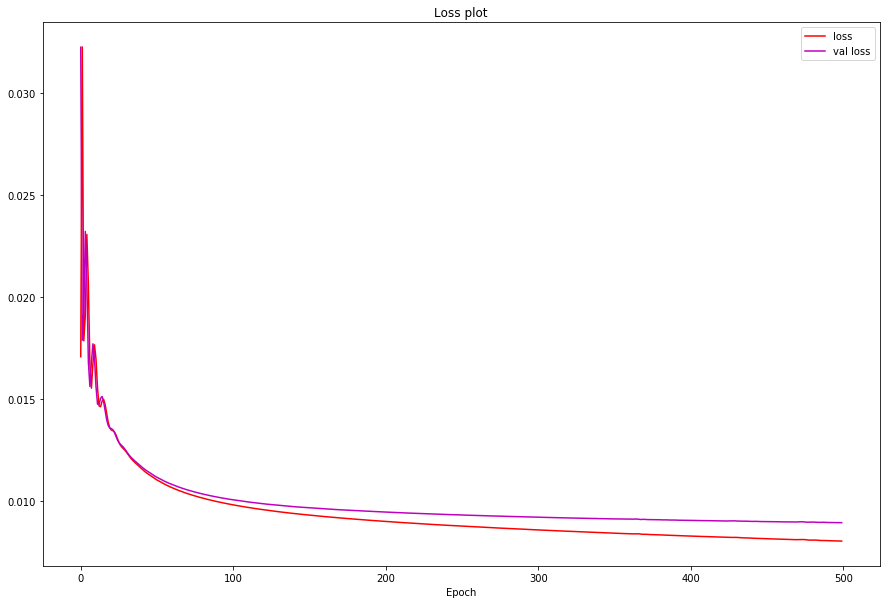

Training Loss before/after: 0.01707281731069088, 0.008040306158363819
Validation Loss before/after: 0.032235950231552124, 0.008943278342485428
Final loss: 0.008040306158363819
Time taken: 16.65336513519287


In [31]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))

In [38]:
n_output = n_mels
special_name = "mels-to-mels -5 to 5 sparsity 11-16-11"
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreFNN Spectrum Decoder with pitch shift", "TimbreFNN_{}_lr{}_epochs{}_in{}_hid{}_out{}_loss{}.pt"
                          .format(special_name, lr, n_epochs, n_input, n_hid, n_output, train_loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([256, 512])
fc2.bias 	 torch.Size([256])
net.0.weight 	 torch.Size([512, 512])
net.0.bias 	 torch.Size([512])
net.2.weight 	 torch.Size([256, 512])
net.2.bias 	 torch.Size([256])
Model saved at model_data\TimbreFNN Spectrum Decoder with pitch shift\TimbreFNN_mels-to-mels -5 to 5 sparsity 11-16-11_lr0.001_epochs500_in512_hid512_out256_loss0.008040306158363819.pt


Text(0.5, 1.0, 'Output-Label for data point 4000')

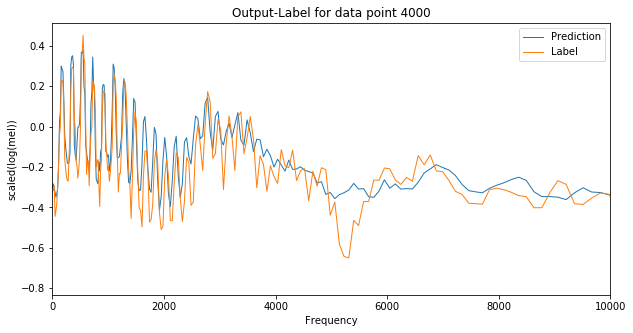

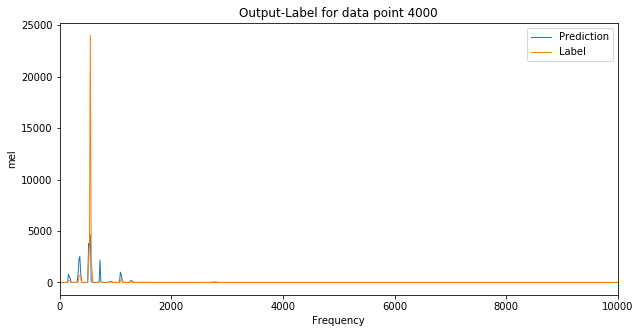

In [41]:
vidx = 3; pIdx = 5; pid = 0; winIdx = 20;
wavIdx = flat_ref_idx(vidx, pIdx, pid)

model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

predictions = model(X_val).cpu().detach().numpy()

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Graphing of a single mel spectra for one datapoint  #
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# data_point = flat_data_idx(wavIdx, winIdx) # Not working after sparsity
data_point = 4000

x_axis = librosa.core.mel_frequencies(n_mels=256, fmin=0.0, fmax=22050.0)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions[data_point], label='Prediction', linewidth=1)
plt.plot(x_axis, Y_val.cpu().detach().numpy()[data_point], label='Label', linewidth=1)
plt.xlim(0, 10000)
plt.xlabel('Frequency')
plt.ylabel('scaled(log(mel))')
plt.legend(loc='best')
plt.title("Output-Label for data point {}".format(data_point))

plt.figure(figsize=(10, 5))
plt.plot(x_axis, np.e ** (predictions[data_point] * max_pitched_mels), label='Prediction', linewidth=1)
plt.plot(x_axis, np.e ** (Y_val.cpu().detach().numpy()[data_point] * max_pitched_mels), label='Label', linewidth=1)
plt.xlim(0, 10000)
plt.xlabel('Frequency')
plt.ylabel('mel')
plt.legend(loc='best')
plt.title("Output-Label for data point {}".format(data_point))

# Testing of the Model for WAV Recreation
These cells can be run as long as you have run the `Global variables/Imports` and `Constants` cells.

To test identity function, simply use the same array for `wav` and `shifted_wav`.

In [54]:
# # # # # # # # # # # # # #
# Reconstruction of a Wav #
# # # # # # # # # # # # # #
def visualize_results(wav, label_wav, shifted_wav, filename, n_ffts, overlap, n_input, n_hid, n_output, n_mels, n_mfcc,
                      model_path, mfcc_path, special_name, 
                      global_max_mels, global_max_mfcc,
                      vidx = 3, pIdx = 5, pid = 0, winIdx = 20):
    wavIdx = flat_ref_idx(vidx, pIdx, pid)
    
    # Get the spectrogram/mfcc data first
    spectrogram = stft(wav, win_length=n_ffts, overlap=overlap, plot=False) 
    wav_mels_prenorm, wav_mfcc_prenorm = ffts_to_mel(spectrogram, n_mels=n_mels, n_mfcc=n_mfcc) 
    wav_mels_prenorm = wav_mels_prenorm.T; wav_mfcc_prenorm = wav_mfcc_prenorm.T;
    
    label_spectrogram = stft(label_wav, win_length=n_ffts, overlap=overlap, plot=False) 
    label_wav_mels_prenorm = ffts_to_mel(label_spectrogram, n_mels=n_mels, skip_mfcc=True) 
    
    shifted_spectrogram = stft(shifted_wav, win_length=n_ffts, overlap=overlap, plot=False) 
    shifted_wav_mels_prenorm = ffts_to_mel(shifted_spectrogram, n_mels=n_mels, skip_mfcc=True) 
    shifted_wav_mels_prenorm = shifted_wav_mels_prenorm.T
    
    ########
    # Mels #
    ########
    # Normalize each mel-spectra by log then to [-1,1]
    wav_mels_logged = np.log(wav_mels_prenorm)
#     max_wav_mels = np.max(np.abs(wav_mels_logged))
    # wav_mels: (29, 256)
#     wav_mels = wav_mels_logged / max_wav_mels
    wav_mels = wav_mels_logged / global_max_mels
    print("Wav mels:", wav_mels.shape)
    
    # Shifted Mels
    
    # Normalize each mel-spectra by log then to [-1,1]
    shifted_wav_mels_logged = np.log(shifted_wav_mels_prenorm)
#     shifted_max_wav_mels = np.max(np.abs(shifted_wav_mels_logged))
    # wav_mels: (29, 256)
#     shifted_wav_mels = shifted_wav_mels_logged / shifted_max_wav_mels
    shifted_wav_mels = shifted_wav_mels_logged / global_max_mels
    print("Shifted Wav mels:", shifted_wav_mels.shape)


    # Create mfcc features on mfccs
    # Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1]
    wav_mfcc_signs = np.sign(wav_mfcc_prenorm)
    wav_mfcc_logged = np.log(np.abs(wav_mfcc_prenorm))
    max_wav_mfcc = np.max(np.abs(wav_mfcc_logged))
    # wav_mfcc: (29, 12)
#     wav_mfcc = wav_mfcc_logged / max_wav_mfcc
    wav_mfcc = wav_mfcc_logged / global_max_mfcc
    wav_mfcc_tensor = torch.Tensor(wav_mfcc)
    print("Wav mfcc:", wav_mfcc.shape)

    ##################
    # Predicted Mels #
    ##################
    model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_ffts=n_ffts, n_mels=n_mels)
    model.load_state_dict(torch.load(model_path, ))
    model.eval()
    
    wav_input = torch.tensor(np.concatenate((wav_mels, shifted_wav_mels), axis=1)).float()
    wav_predicted = model(wav_input).detach().numpy();
#     wav_denorm_mels = np.e ** (wav_predicted * shifted_max_wav_mels)
    wav_denorm_mels = np.e ** (wav_predicted * global_max_mels)
    print("Denormalized prediction:", wav_denorm_mels.shape)

    ################
    # Waveform/Wav # 
    ################
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Waveform Confirmation", fontsize=16)
    
    gl_abs_waveform = librosa.feature.inverse.mel_to_audio(
        wav_mels_prenorm.T, sr=44100, n_fft=n_ffts, 
        hop_length=compute_hop_length(n_ffts, overlap), 
        win_length=n_ffts)
    sio.wavfile.write('{} Original-{}'
                  .format(special_name, filename), 44100, gl_abs_waveform)
    ax[0][0].plot(gl_abs_waveform)
    ax[0][0].set_title("Original waveform: {}".format(wav_mels_prenorm.shape))
    
    gl_abs_waveform = librosa.feature.inverse.mel_to_audio(
        shifted_wav_mels_prenorm.T, sr=44100, n_fft=n_ffts, 
        hop_length=compute_hop_length(n_ffts, overlap), 
        win_length=n_ffts)
    sio.wavfile.write('{} Shifted-{}'
                  .format(special_name, filename), 44100, gl_abs_waveform)
    ax[0][1].plot(gl_abs_waveform)
    ax[0][1].set_title("Shifted waveform: {}".format(shifted_wav_mels_prenorm.shape))
    
    gl_abs_waveform = librosa.feature.inverse.mel_to_audio(
        label_wav_mels_prenorm, sr=44100, n_fft=n_ffts, 
        hop_length=compute_hop_length(n_ffts, overlap), 
        win_length=n_ffts)
    sio.wavfile.write('{} Label-{}'
                  .format(special_name, filename), 44100, gl_abs_waveform)
    ax[1][0].plot(gl_abs_waveform)
    ax[1][0].set_title("Label waveform: {}".format(shifted_wav_mels_prenorm.shape))
    
    gl_abs_waveform = librosa.feature.inverse.mel_to_audio(
        wav_denorm_mels.T, sr=44100, n_fft=n_ffts, 
        hop_length=compute_hop_length(n_ffts, overlap), 
        win_length=n_ffts)
    sio.wavfile.write('{} Decoded-{}'
                  .format(special_name, filename), 44100, gl_abs_waveform)
    ax[1][1].plot(gl_abs_waveform)
    ax[1][1].set_title("Decoded waveform: {}".format(wav_denorm_mels.shape))
    
    ######################
    # Plots to visualize #
    ######################

    plot_mel_spectrogram(wav_mels_prenorm.T, 44100, file_name="{}".format(filename))
    plot_mel_spectrogram(wav_denorm_mels.T, 44100, "Reconstructed")

    x_axis = librosa.core.mel_frequencies(n_mels=256, fmin=0.0, fmax=22050.0)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, wav_denorm_mels[winIdx], label='Decoded', linewidth=1)
    plt.plot(x_axis, wav_mels_prenorm[winIdx], label='Original', linewidth=1)
    plt.plot(x_axis, label_wav_mels_prenorm.T[winIdx], label='Label', linewidth=1)
    plt.plot(x_axis, shifted_wav_mels_prenorm[winIdx], label='Shifted', linewidth=1)

    plt.xlim(0, 1500)
    plt.xlabel('Frequency')
    plt.ylabel('mel')
    plt.legend(loc='best')
    plt.title("Output-Label for data point (Window [{}] of {})".format(winIdx, flat_data_ref_list[wavIdx]))

Wav mels: (58, 256)
Shifted Wav mels: (58, 256)
Wav mfcc: (58, 40)
Denormalized prediction: (58, 256)


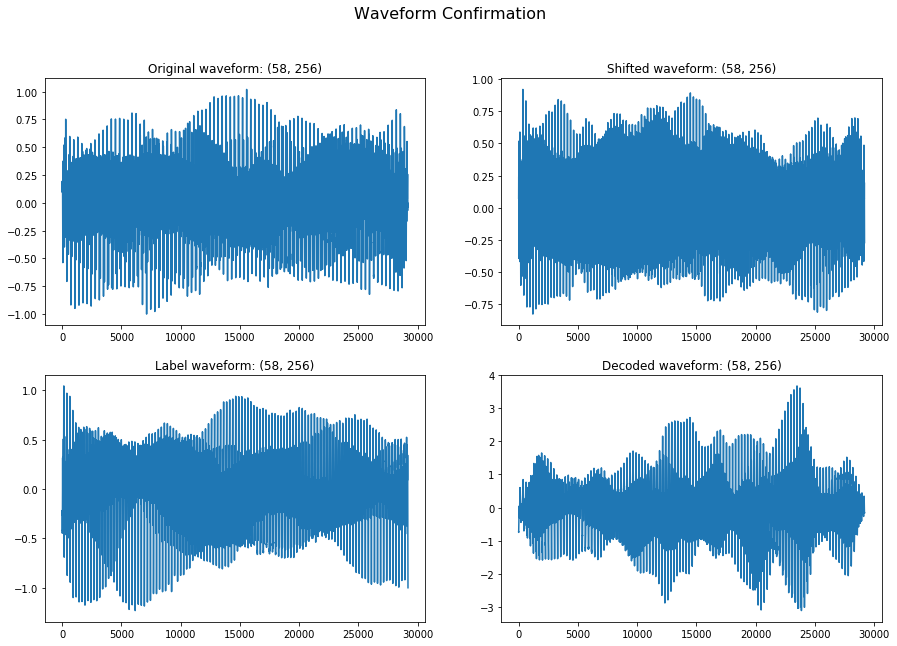

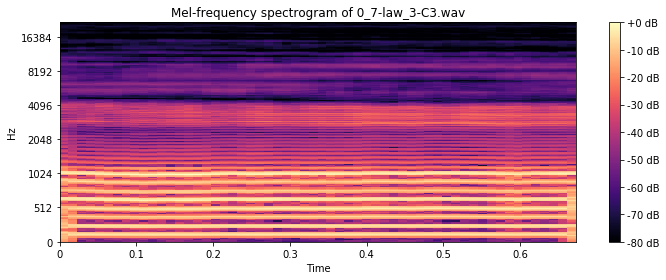

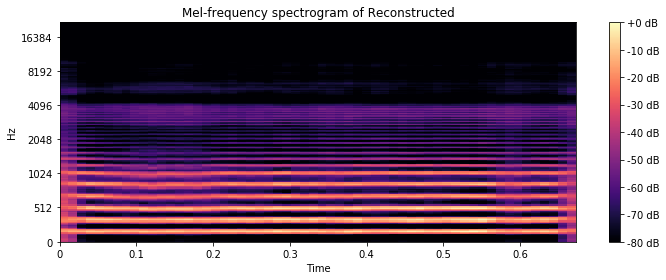

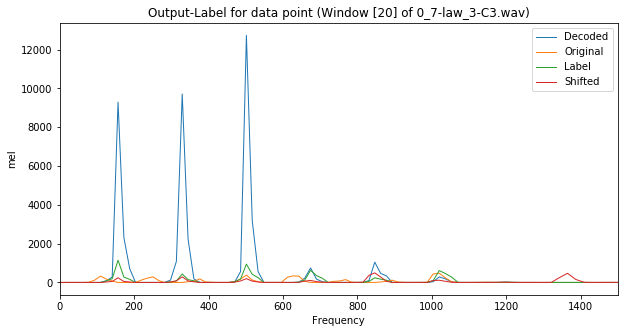

In [55]:
# Calling the function 
vidx = 7; pIdx = 3; pid = 0; shift_amt = 5
wavIdx = flat_ref_idx(vidx, pIdx, pid); labelWavIdx = flat_ref_idx(vidx, pIdx + shift_amt, pid);
filenames = [ flat_data_ref_list[wavIdx], flat_data_ref_list[labelWavIdx] ]
wav, labelWav = load_wav_files(os.path.join("Data", "dataset"), filenames)

overlap = 0.75
shifted_wav, _ = resample_pitch_shift(np.array([wav]), shift_amt, overlap, n_ffts)
shifted_wav = shifted_wav[0]
global_max_mels = max_mels; global_max_mfcc = max_mfcc; 

special_name="shift-4"

model_path = os.path.join("model_data", "TimbreFNN Spectrum Decoder with pitch shift", 
                          "TimbreFNN_mels-to-mels -5 to 5 sparsity 11-16-11_lr0.001_epochs500_in512_hid512_out256_loss0.008040306158363819.pt")
mfcc_path = os.path.join('model_data', 'TimbreFNNDecoder_mels-mels_0.001_500_40_256_260_2048_0.0019322590669617057.pt')

visualize_results(wav, labelWav, shifted_wav, filenames[0], 
                  n_ffts, overlap, n_input, n_hid, n_output, 
                  n_mels, n_mfcc,
                  model_path, mfcc_path, special_name, 
                  global_max_mels, global_max_mfcc,
                  vidx = vidx, pIdx = pIdx, pid = pid, winIdx = 20)